<center><h1>Capstone Project - The Battle of Neighborhoods</h1></center>
<center><h2>Dinh-Dung Le</h2></center>
<center><h2>2020.03.08</h2></center>

# 1. Introduction/Business Problem 
## 1.1. Introduction
I used to live in Japan 3 years and really impressed by the convenience of the railway system. Tokyo especially is home to the world’s busiest train stations, with the capital’s rail operators handling a combined 13 billion passenger trips annually. From the station, all the needs of human life can be reach easily. Many restaurants, shopping malls are usually located near the stations.

## 1.2. Problem to be resolved:
- In this project, I will try to use Data Science techniques to investigate about **the prospects of restaurant at station in Tokyo, Japan.**

## 1.3. Interested Audience
- I believe the methodology, tools and strategy used in this project is relevant for a person or entity considering moving to Tokyo and want to find their country’s food.
- Likewise, it can be helpful approach to explore the opening of a new business. The use of FourSquare data and mapping techniques combined with data analysis will help resolve the key questions arisen. 
- Lastly, this project is a good practical case for a person developing Data Science skills.

# 2. Data Section
## 2.1. Data Requirements:
- Geodata for railway stations in central Tokyo with venues established using Foursquare. 
- List of metro train stations is at: https://en.wikipedia.org/wiki/List_of_Tokyo_Metro_stations

## 2.2. Data Sources, Data Processing and Tools used
- Tokyo data and map is to be created with use of Nominatim , Foursquare and Folium mapping.
- List of railway stations and Wards in Tokyo is collected using BeautifulSoup. 
- seaborn is also used for visualization in investigated results.

# 3. Methodology
# 4. Implementation (Step by step)
## 4.1 Import required libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

!conda install -c conda-forge folium --yes 
import folium # map rendering library

!pip install beautifulsoup4
from bs4 import BeautifulSoup

import seaborn as sns

from sklearn.cluster import KMeans 
print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.21.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

## 4.2. Collect information about  Railway stations and Wards in Tokyo 
- Source: https://en.wikipedia.org/wiki/List_of_Tokyo_Metro_station

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_Tokyo_Metro_stations'
page = requests.get(url).text
soup = BeautifulSoup(page, 'html.parser')
tables = soup.find_all('table',{'class':'wikitable sortable'})

## 4.3. Data cleaning 
- Since the Wikipedia page consists of two seperate tables. I collected and concatened into 1 table for later steps.
- Remove the stations which appear in both table (duplicated).
- Remove unnecessary columns: Line, Open day

In [3]:

# Table 1
row = []
for tr in tables[0].find_all('tr'):                                           
    if tr.find_all('th') == []:
        row.append([td.get_text(strip=True) for td in tr.find_all('td')]) 
column_names = ['Station', 'Line', 'Ward', 'Opening Day','Design', 'Daily ridership']
df0 = pd.DataFrame(row, columns=column_names)
# Table 2
row = []
for tr in tables[1].find_all('tr'):                                           
    if tr.find_all('th') == []:
        row.append([td.get_text(strip=True) for td in tr.find_all('td')]) 
column_names = ['Station', 'Line', 'Ward', 'Opening Day','Design', 'Daily ridership']
df1 = pd.DataFrame(row, columns=column_names)

# Combine two table into one
df = pd.concat([df0, df1])



In [4]:

# Option: sort name of station
df.sort_values("Station", inplace = True) 
# Remove dupicated stations
df.drop_duplicates(subset ="Station", 
                     keep = False, inplace = True) 
# Remove unused columns
df.drop(['Line','Opening Day' ], axis=1, inplace=True)
# Reset index of df from 0
df.index = np.arange(0, len(df))
df.tail(10)



,Station,Ward,Design,Daily ridership
130,Yotsuya,Shinjuku,ElevatedUnderground,"125,084"
131,Yotsuya-Sanchōme,Shinjuku,Underground,"46,732"
132,Yoyogi-Kōen,Shibuya,Underground,"28,031"
133,Yoyogi-Uehara,Shibuya,Elevated,"278,836"
134,Yushima,Bunkyō,Underground,"35,880"
135,Yūrakuchō,Chiyoda,Underground,"174,378"
136,Zōshigaya,Toshima,Underground,"18,381"
137,Ōji,Kita,Underground,"63,317"
138,Ōji-Kamiya,Kita,Underground,"35,406"
139,Ōtemachi,Chiyoda,Underground,"338,955"


## 4.4. Data cleaning (cont.)
There are two rows have incorrect information in table we have got. 
- Row [9] Baraki-Nakayama	Funabashi(Chiba). this station seems belong to Chiba Perfecture. 
- Row [51] Kokkai Gijidō-maeTameike-Sannō. In fact, this is the name of two stations: Kokkai Gijidō-mae and Tameike-Sannō.

In this project, I decided removing two rows from the table. 

In [5]:

# Remove wrong station in the table index 9 and 51
df.drop(df.index[9], inplace=True)
# [51] become [50] after remove [9] 
df.drop(df.index[50], inplace=True)
# Reset index from 0
df.index = np.arange(len(df))
#df



## 4.5. Data preparing
- Using Nominatium to search for the latitude and longitude of the stations.
- Add latitude and longitude to the table
- Arrange the table.

In [6]:
# convert the df['Station'] to the list names of the station
location = [x for x in df['Station'].unique().tolist() if type(x) == str]
latitude = []
longitude =  []
for i in range(0, len(location)):
    if(type(location[i]) == str):
        ctr=0
        while True:
            try:
                address = location[i] + ' Tokyo'
                geolocator = Nominatim(user_agent="japan_explorer")
                loc = geolocator.geocode(address)
                latitude.append(loc.latitude)
                longitude.append(loc.longitude)
                print('{}. The geograpical coordinate of location are {}, {}.'.format(i, loc.latitude, loc.longitude))
            except:
                ctr+=1
                if(ctr==7):
                    print(i)
                    latitude.append(address)
                    longitude.append(address)
                    break
                continue
            break

0. The geograpical coordinate of location are 35.7834478, 139.7221.
1. The geograpical coordinate of location are 35.6716786, 139.7356224.
2. The geograpical coordinate of location are 35.6762983, 139.7374398.
3. The geograpical coordinate of location are 35.6997364, 139.7712503.
4. The geograpical coordinate of location are 35.6727491, 139.7240607.
5. The geograpical coordinate of location are 35.7099289, 139.7311417.
6. The geograpical coordinate of location are 35.6951289, 139.767457.
7. The geograpical coordinate of location are 35.7621884, 139.825389.
8. The geograpical coordinate of location are 35.6551317, 139.7370828.
9. The geograpical coordinate of location are 35.7699134, 139.6441215.
10. The geograpical coordinate of location are 35.7769372, 139.6309689.
11. The geograpical coordinate of location are 35.6464378, 139.7102101.
12. The geograpical coordinate of location are 35.7095373, 139.7335743.
13. The geograpical coordinate of location are 35.6704896, 139.7178719.
14. The

In [7]:
df['Latitude'] = latitude 
df['Longitude'] = longitude 

In [8]:
df = df[['Ward','Station','Latitude', 'Longitude']]
df.tail(10)

,Ward,Station,Latitude,Longitude
128,Shinjuku,Yotsuya,35.684861,139.730789
129,Shinjuku,Yotsuya-Sanchōme,35.687987,139.720570
130,Shibuya,Yoyogi-Kōen,35.670648,139.695601
131,Shibuya,Yoyogi-Uehara,35.669008,139.679787
132,Bunkyō,Yushima,35.707333,139.770010
133,Chiyoda,Yūrakuchō,35.674423,139.761674
134,Toshima,Zōshigaya,35.720251,139.714775
135,Kita,Ōji,35.752347,139.738275
136,Kita,Ōji-Kamiya,35.765007,139.735780
137,Chiyoda,Ōtemachi,35.686757,139.763616


## 4.6 Fist look at the collected data

In [9]:
# Check the number of station in Ward Minato
df[df['Ward']=='Minato'].head(3)

,Ward,Station,Latitude,Longitude
1,Minato,Akasaka,35.671679,139.735622
2,Minato,Akasaka Mitsuke,35.676298,139.737440
4,Minato,Aoyama-Itchōme,35.672749,139.724061


In [10]:
#Count number of station per Ward
df.groupby('Ward')['Station'].count()

Ward
Adachi               2
Arakawa              3
Bunkyō              12
Chiyoda             18
ChiyodaShinjuku      1
Chūō                14
Edogawa              2
Funabashi(Chiba)     1
Ichikawa(Chiba)      3
Itabashi             1
Kita                 5
Kōtō                10
Meguro               1
Minato              15
Nakano               5
Nerima               4
Shibuya              5
Shinagawa            1
Shinjuku            13
Suginami             5
Sumida               1
Taitō                8
Toshima              6
Urayasu(Chiba)       1
Wakō(Saitama)        1
Name: Station, dtype: int64

## 4.7. First look at the data in map
- Using Nominatim and Folium to show the stations and ward in the map of Tokyo.

In [11]:
wards = df['Ward'].unique().tolist()
ward_color = {}
for ward in wards:
    ward_color[ward]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3)) #Random color

In [12]:
address = 'Tokyo, Japan'
geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
tokyo_latitude = location.latitude
tokyo_longitude = location.longitude
print('The geograpical coordinate of Tokyo, Japan are {}, {}.'.format(tokyo_latitude, tokyo_longitude))

The geograpical coordinate of Tokyo, Japan are 35.6828387, 139.7594549.


In [13]:
# create map of Tokyo using latitude and longitude values
map_tokyo = folium.Map(location=[tokyo_latitude, tokyo_longitude], zoom_start=11, control_scale=True)

# add markers to map
for lat, lng, wad, sta in zip(df['Latitude'], 
                                            df['Longitude'],
                                            df['Ward'], 
                                            df['Station']):
    label_text = wad + ' - ' + sta
    label = folium.Popup(label_text, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        tooltip = label_text,
        radius=4,
        popup=label,
        color=ward_color[wad],
        fill=True,
        fill_color=ward_color[wad],
        fill_opacity=0.7).add_to(map_tokyo)  
    
map_tokyo

## 4.8. Use the Foursquare API to explore the stations
- Persional informations to access the Foursquare API

In [50]:


CLIENT_ID = 'ID' #'your-client-ID' # your Foursquare ID
CLIENT_SECRET = 'SECRET' #'your-client-secret' # your Foursquare Secret
VERSION = '20200309'
print('My credentails:')
print('My CLIENT_ID: ' + CLIENT_ID)
print('My CLIENT_SECRET:' + CLIENT_SECRET)




My credentails:
My CLIENT_ID: ID
My CLIENT_SECRET:SECRET


- Because the stations are not too far from each others. The radius of 500 is used in this project. Each station is also limited at 200 venues.

In [16]:
radius = 500
LIMIT = 100

def getNearbyVenues(names, cities, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, city, lat, lng in zip(names, cities, latitudes, longitudes):
        print('Processing Ward: {}, Station: {}'.format(city, name))
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            city,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Station',
                             'Ward',
                             'Sta_Lat', 
                             'Sta_Log', 
                             'Venue', 
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Category']
    
    return(nearby_venues)

In [17]:

Tokyo_Venues = getNearbyVenues(names = df['Station'], cities = df['Ward'],
                                   latitudes = df['Latitude'],
                                   longitudes = df['Longitude']
                                  )


Processing Ward: Kita, Station: Akabane Iwabuchi
Processing Ward: Minato, Station: Akasaka
Processing Ward: Minato, Station: Akasaka Mitsuke
Processing Ward: Chiyoda, Station: Akihabara
Processing Ward: Minato, Station: Aoyama-Itchōme
Processing Ward: Taitō, Station: Asakusa
Processing Ward: Chiyoda, Station: Awajichō
Processing Ward: Adachi, Station: Ayase
Processing Ward: Minato, Station: Azabu-Jūban
Processing Ward: Nerima, Station: Chikatetsu Akatsuka
Processing Ward: Itabashi, Station: Chikatetsu Narimasu
Processing Ward: Shibuya, Station: Ebisu
Processing Ward: Bunkyō, Station: Edogawabashi
Processing Ward: Minato, Station: Gaienmae
Processing Ward: Chūō, Station: Ginza
Processing Ward: Chūō, Station: Ginza-itchōme
Processing Ward: Bunkyō, Station: Gokokuji
Processing Ward: Ichikawa(Chiba), Station: Gyōtoku
Processing Ward: Chiyoda, Station: Hanzōmon
Processing Ward: Chūō, Station: Hatchōbori
Processing Ward: Nerima, Station: Heiwadai
Processing Ward: Chiyoda, Station: Hibiya
Pro

## 4.9. Second looking at the collected data from Foursquare
- Total numbers of venues we have got. 

In [18]:
print('Total number of venues in Tokyo: ', Tokyo_Venues.shape[0])
Tokyo_Venues.tail(10)

Total number of venues in Tokyo:  9579


,Station,Ward,Sta_Lat,Sta_Log,Venue,Venue Latitude,Venue Longitude,Venue Category
9569,Ōtemachi,Chiyoda,35.686757,139.763616,SCEnT house den Marunouchi,35.684047,139.762416,Asian Restaurant
9570,Ōtemachi,Chiyoda,35.686757,139.763616,Crown (クラウン),35.684525,139.761243,French Restaurant
9571,Ōtemachi,Chiyoda,35.686757,139.763616,Freshness Burger (フレッシュネスバーガー),35.687588,139.766096,Burger Joint
9572,Ōtemachi,Chiyoda,35.686757,139.763616,Craft Beer Market,35.688275,139.765194,Beer Bar
9573,Ōtemachi,Chiyoda,35.686757,139.763616,稲荷湯,35.690098,139.766236,Bath House
9574,Ōtemachi,Chiyoda,35.686757,139.763616,Shodoten (小洞天),35.685703,139.763902,Chinese Restaurant
9575,Ōtemachi,Chiyoda,35.686757,139.763616,Mouyan Curry (もうやんカレー),35.686196,139.761700,Japanese Curry Restaurant
9576,Ōtemachi,Chiyoda,35.686757,139.763616,Orchestra Vino (オルケストラヴィーノ),35.688340,139.765523,Italian Restaurant
9577,Ōtemachi,Chiyoda,35.686757,139.763616,時津洋 神田店,35.690806,139.764572,Nabe Restaurant
9578,Ōtemachi,Chiyoda,35.686757,139.763616,江戸城跡,35.682758,139.761370,Historic Site


- Number of Venues in each station

In [19]:
#Obtain the number of venues per Station
venues_count = Tokyo_Venues.groupby(['Ward','Station'])['Venue Category'].count().to_frame()
venues_count.head(10)

Venue Category
Ward    Station                       
Adachi  Ayase                       70
        Kita-Ayase                  51
Arakawa Machiya                     46
        Minami-Senju                41
        Nishi-Nippori               50
Bunkyō  Edogawabashi                56
        Gokokuji                    32
        Hon-Komagome                37
        Hongō-Sanchōme              36
        Kōrakuen                   100

In [20]:
#Fix title and remove multiindex
venues_count.rename(columns={'Venue Category':'N_venues'}, inplace=True)
venues_count.reset_index(inplace=True)
venues_count.head(10)

,Ward,Station,N_venues
0,Adachi,Ayase,70
1,Adachi,Kita-Ayase,51
2,Arakawa,Machiya,46
3,Arakawa,Minami-Senju,41
4,Arakawa,Nishi-Nippori,50
5,Bunkyō,Edogawabashi,56
6,Bunkyō,Gokokuji,32
7,Bunkyō,Hon-Komagome,37
8,Bunkyō,Hongō-Sanchōme,36
9,Bunkyō,Kōrakuen,100


- Sort the stations by venues 

In [21]:
#Sort by number of venues
venues_count.sort_values(by='N_venues', ascending=False, inplace=True)
venues_count.head(10)

,Ward,Station,N_venues
137,Wakō(Saitama),Wakō-shi,100
103,Shinjuku,Higashi-Shinjuku,100
30,Chiyoda,Suehirochō,100
33,Chiyoda,Yūrakuchō,100
34,Chiyoda,Ōtemachi,100
35,ChiyodaShinjuku,Iidabashi,100
36,Chūō,Ginza,100
37,Chūō,Ginza-itchōme,100
97,Shibuya,Ebisu,100
39,Chūō,Higashi-Ginza,100


- Plot number of venues registered per stations

In [22]:
sns.set()
sns.set(rc={'figure.figsize':(20,5)})

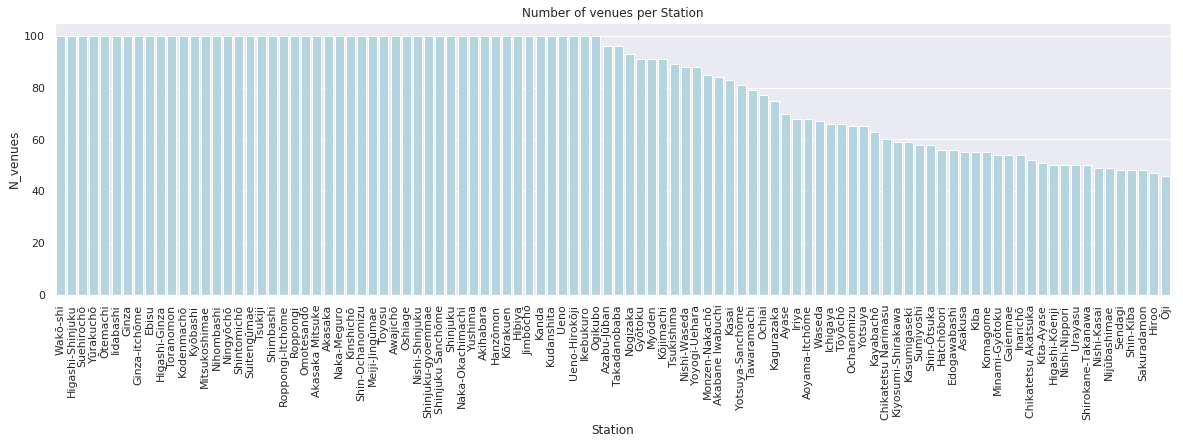

In [23]:
#Plot number of venues registered per neighborhood 
ax = sns.barplot(x='Station',y='N_venues',data=venues_count[:100], color='lightblue')
ax.set_title('Number of venues per Station')
ax.set_xticklabels(labels=venues_count['Station'],rotation=90);

In [24]:
#Lets explore the venues for one Neighborhood in Madrid
Tokyo_Venues[Tokyo_Venues['Station']=='Ayase'].head(10)

,Station,Ward,Sta_Lat,Sta_Log,Venue,Venue Latitude,Venue Longitude,Venue Category
607,Ayase,Adachi,35.762188,139.825389,串のこたに,35.761212,139.826826,Sake Bar
608,Ayase,Adachi,35.762188,139.825389,もつ焼 大松 綾瀬東口本店,35.761539,139.826471,Yakitori Restaurant
609,Ayase,Adachi,35.762188,139.825389,Shitara (シータラ),35.763623,139.826732,Indian Restaurant
610,Ayase,Adachi,35.762188,139.825389,らーめんしょっぷ 中吉,35.763691,139.826754,Ramen Restaurant
611,Ayase,Adachi,35.762188,139.825389,ラパンラパン,35.764698,139.827564,Bakery
612,Ayase,Adachi,35.762188,139.825389,Hidakaya (日高屋),35.762438,139.826525,Chinese Restaurant
613,Ayase,Adachi,35.762188,139.825389,Burger King (バーガーキング),35.762340,139.823960,Fast Food Restaurant
614,Ayase,Adachi,35.762188,139.825389,Ito Yokado (イトーヨーカドー 綾瀬店),35.762506,139.825517,Supermarket
615,Ayase,Adachi,35.762188,139.825389,KFC (ケンタッキーフライドチキン),35.762455,139.826687,Fried Chicken Joint
616,Ayase,Adachi,35.762188,139.825389,タイトーステーション 綾瀬店,35.762179,139.823089,Arcade


## 4.10. Concentrate only on the restaurants 
- Create a new dataframe with only restaurant on the Venue Category

In [25]:

# Create a Data-Frame out of it to Concentrate Only on Restaurants 
Tokyo_only_restaurant = Tokyo_Venues[Tokyo_Venues['Venue Category']\
                                                          .str.contains('Restaurant')].reset_index(drop=True)
Tokyo_only_restaurant.index = np.arange(1, len(Tokyo_only_restaurant)+1)
print ("Shape of the Data-Frame with Venue Category only Restaurant: ", Tokyo_only_restaurant.shape)
Tokyo_only_restaurant.tail(3)


Shape of the Data-Frame with Venue Category only Restaurant:  (3795, 8)


,Station,Ward,Sta_Lat,Sta_Log,Venue,Venue Latitude,Venue Longitude,Venue Category
3793,Ōtemachi,Chiyoda,35.686757,139.763616,Mouyan Curry (もうやんカレー),35.686196,139.761700,Japanese Curry Restaurant
3794,Ōtemachi,Chiyoda,35.686757,139.763616,Orchestra Vino (オルケストラヴィーノ),35.688340,139.765523,Italian Restaurant
3795,Ōtemachi,Chiyoda,35.686757,139.763616,時津洋 神田店,35.690806,139.764572,Nabe Restaurant


- Number of Restaurants in each station

In [26]:
#Obtain the number of restaurants per Station
venues_counts = Tokyo_only_restaurant.groupby(['Ward','Station'])['Venue Category'].count().to_frame()
#venues_counts.head(10)

#Fix title and remove multiindex
venues_counts.rename(columns={'Venue Category':'N_venues'}, inplace=True)
venues_counts.reset_index(inplace=True)
venues_counts.head(10)

#Sort by number of venues
#venues_counts.sort_values(by='N_venues', ascending=False, inplace=True)
#venues_counts.head(10)
#sns.set()
#sns.set(rc={'figure.figsize':(20,5)})

#Plot number of restaurants registered per station
#ax = sns.barplot(x='Station',y='N_venues',data=venues_counts[:50], color='lightblue')
#ax.set_title('Number of restaurant per Station')
#ax.set_xticklabels(labels=venues_count['Station'],rotation=90);

,Ward,Station,N_venues
0,Adachi,Ayase,21
1,Adachi,Kita-Ayase,13
2,Arakawa,Machiya,14
3,Arakawa,Minami-Senju,12
4,Arakawa,Nishi-Nippori,20
5,Bunkyō,Edogawabashi,24
6,Bunkyō,Gokokuji,13
7,Bunkyō,Hon-Komagome,12
8,Bunkyō,Hongō-Sanchōme,16
9,Bunkyō,Kōrakuen,23


- Plot number of restaurants registered per station

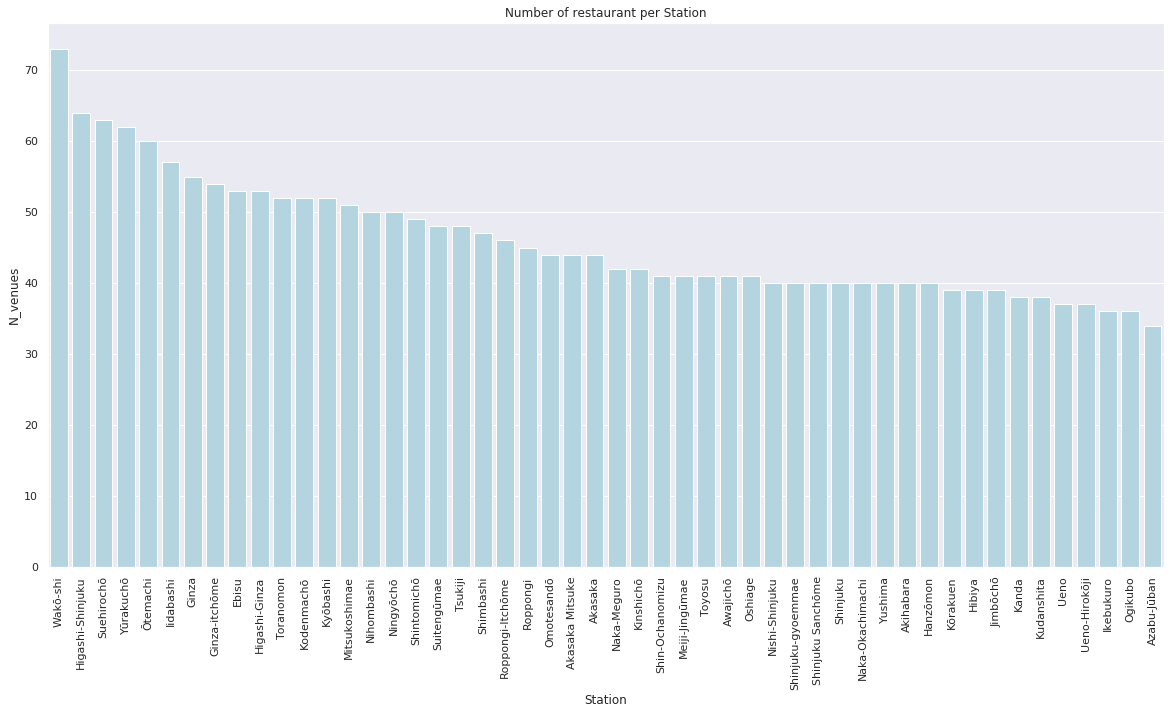

In [27]:
#Sort by number of venues
venues_counts.sort_values(by='N_venues', ascending=False, inplace=True)

sns.set()
sns.set(rc={'figure.figsize':(20,10)})

#Plot number of restaurants registered per station
ay = sns.barplot(x='Station',y='N_venues',data=venues_counts[:50], color='lightblue')
ay.set_title('Number of restaurant per Station')
ay.set_xticklabels(labels=venues_count['Station'],rotation=90);

## 4.11. Clustering Tokyo stations

In [28]:

#One hot encoding
venues_onehot = pd.get_dummies(Tokyo_only_restaurant[['Venue Category']], prefix="", prefix_sep="")



In [29]:
venues_onehot.head(3)

,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Bangladeshi Restaurant,Beijing Restaurant,Belarusian Restaurant,Belgian Restaurant,Brazilian Restaurant,Burmese Restaurant,Cantonese Restaurant,Chinese Restaurant,Comfort Food Restaurant,Czech Restaurant,Dim Sum Restaurant,Donburi Restaurant,Dongbei Restaurant,Dumpling Restaurant,Eastern European Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Henan Restaurant,Himalayan Restaurant,Hong Kong Restaurant,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Kaiseki Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Kushikatsu Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Monjayaki Restaurant,Multicuisine Indian Restaurant,Nabe Restaurant,New American Restaurant,North Indian Restaurant,Okonomiyaki Restaurant,Persian Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Soba Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sri Lankan Restaurant,Sukiyaki Restaurant,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tempura Restaurant,Thai Restaurant,Theme Restaurant,Tonkatsu Restaurant,Turkish Restaurant,Udon Restaurant,Unagi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yakitori Restaurant,Yoshoku Restaurant,Yunnan Restaurant
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:

# Add the stations column back to the dataframe
venues_onehot['Station'] = Tokyo_only_restaurant['Station']
venues_onehot.head(3)


,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Bangladeshi Restaurant,Beijing Restaurant,Belarusian Restaurant,Belgian Restaurant,Brazilian Restaurant,Burmese Restaurant,Cantonese Restaurant,Chinese Restaurant,Comfort Food Restaurant,Czech Restaurant,Dim Sum Restaurant,Donburi Restaurant,Dongbei Restaurant,Dumpling Restaurant,Eastern European Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Henan Restaurant,Himalayan Restaurant,Hong Kong Restaurant,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Kaiseki Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Kushikatsu Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Monjayaki Restaurant,Multicuisine Indian Restaurant,Nabe Restaurant,New American Restaurant,North Indian Restaurant,Okonomiyaki Restaurant,Persian Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Soba Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sri Lankan Restaurant,Sukiyaki Restaurant,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tempura Restaurant,Thai Restaurant,Theme Restaurant,Tonkatsu Restaurant,Turkish Restaurant,Udon Restaurant,Unagi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yakitori Restaurant,Yoshoku Restaurant,Yunnan Restaurant,Station
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,Akabane Iwabuchi
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Akabane Iwabuchi
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Akabane Iwabuchi


In [31]:

# Average per station
venues_grouped = venues_onehot.groupby(['Station']).mean().reset_index()
venues_grouped.sample(15)



,Station,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Bangladeshi Restaurant,Beijing Restaurant,Belarusian Restaurant,Belgian Restaurant,Brazilian Restaurant,Burmese Restaurant,Cantonese Restaurant,Chinese Restaurant,Comfort Food Restaurant,Czech Restaurant,Dim Sum Restaurant,Donburi Restaurant,Dongbei Restaurant,Dumpling Restaurant,Eastern European Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Henan Restaurant,Himalayan Restaurant,Hong Kong Restaurant,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Kaiseki Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Kushikatsu Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Monjayaki Restaurant,Multicuisine Indian Restaurant,Nabe Restaurant,New American Restaurant,North Indian Restaurant,Okonomiyaki Restaurant,Persian Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Soba Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sri Lankan Restaurant,Sukiyaki Restaurant,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tempura Restaurant,Thai Restaurant,Theme Restaurant,Tonkatsu Restaurant,Turkish Restaurant,Udon Restaurant,Unagi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yakitori Restaurant,Yoshoku Restaurant,Yunnan Restaurant
72,Nakano Sakaue,0.000000,0.0,0.050000,0.000,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.200000,0.0,0.0,0.0,0.100000,0.000000,0.000000,0.0,0.0,0.050000,0.0,0.000000,0.00000,0.000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.050000,0.0,0.000000,0.050000,0.150000,0.000000,0.0,0.000000,0.0,0.050000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.050000,0.000000,0.0,0.000000,0.00000,0.00,0.000000,0.0,0.05,0.000000,0.0,0.000000,0.000000,0.0,0.050000,0.0,0.050000,0.000000,0.000000,0.000000,0.050000,0.050000,0.0
125,Wakō-shi,0.000000,0.0,0.000000,0.025,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.02500,0.025,0.000000,0.0,0.0,0.0,0.0,0.000000,0.050000,0.0,0.050000,0.025000,0.200000,0.025000,0.0,0.025000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.050000,0.050000,0.0,0.0,0.025000,0.075000,0.0,0.025000,0.000000,0.0,0.025000,0.00000,0.05,0.075000,0.0,0.00,0.000000,0.0,0.050000,0.000000,0.0,0.000000,0.0,0.050000,0.000000,0.000000,0.000000,0.025000,0.050000,0.0
42,Kasumigaseki,0.000000,0.0,0.000000,0.000,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.045455,0.0,0.0,0.0,0.045455,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.045455,0.0,0.045455,0.000000,0.090909,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.090909,0.090909,0.0,0.0,0.045455,0.045455,0.0,0.045455,0.045455,0.0,0.000000,0.00000,0.00,0.000000,0.0,0.00,0.045455,0.0,0.000000,0.045455,0.0,0.045455,0.0,0.090909,0.000000,0.000000,0.045455,0.045455,0.045455,0.0
56,Machiya,0.000000,0.0,0.000000,0.000,0.071429,0.0,0.0,0.000000,0.00000,0.0,0.0,0.071429,0.0,0.0,0.0,0.071429,0.000000,0.000000,0.0,0.0,0.142857,0.0,0.000000,0.00000,0.000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.071429,0.0,0.142857,0.071429,0.071429,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.142857,0.142857,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.00,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
126,Waseda,0.032258,0.0,0.032258,0.000,0.00

In [32]:
# Borrow the function from the lab. Sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [33]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Station']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
stations_venues_sorted = pd.DataFrame(columns=columns)
stations_venues_sorted['Station'] = venues_grouped['Station']

for ind in np.arange(venues_grouped.shape[0]):
    stations_venues_sorted.iloc[ind, 1:] = return_most_common_venues(venues_grouped.iloc[ind, :], num_top_venues)

stations_venues_sorted.head(20)
print(stations_venues_sorted.shape)

(137, 11)


In [34]:
stations_venues_sorted.sort_values(by=['Station'])

,Station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Akabane Iwabuchi,Ramen Restaurant,Italian Restaurant,Japanese Restaurant,Japanese Curry Restaurant,Kushikatsu Restaurant,Donburi Restaurant,Chinese Restaurant,Indian Restaurant,Persian Restaurant,Restaurant
1,Akasaka,Japanese Restaurant,Chinese Restaurant,Kaiseki Restaurant,Ramen Restaurant,Italian Restaurant,Szechuan Restaurant,Nabe Restaurant,Korean Restaurant,Sushi Restaurant,Tonkatsu Restaurant
2,Akasaka Mitsuke,Japanese Restaurant,Szechuan Restaurant,Ramen Restaurant,Chinese Restaurant,Italian Restaurant,Soba Restaurant,Sushi Restaurant,Seafood Restaurant,American Restaurant,Unagi Restaurant
3,Akihabara,Ramen Restaurant,Donburi Restaurant,Tonkatsu Restaurant,Sushi Restaurant,Chinese Restaurant,Szechuan Restaurant,Soba Restaurant,Brazilian Restaurant,Kebab Restaurant,Yoshoku Restaurant
4,Aoyama-Itchōme,Italian Restaurant,Ramen Restaurant,Japanese Restaurant,Chinese Restaurant,Soba Restaurant,Sushi Restaurant,Japanese Curry Restaurant,Tonkatsu Restaurant,Thai Restaurant,Udon Restaurant
5,Asakusa,Ramen Restaurant,Chinese Restaurant,Soba Restaurant,Japanese Curry Restaurant,Sushi Restaurant,Udon Restaurant,Kushikatsu Restaurant,Tonkatsu Restaurant,Yoshoku Restaurant,Indian Restaurant
6,Awajichō,Ramen Restaurant,Japanese Curry Restaurant,Soba Restaurant,Tonkatsu Restaurant,Japanese Restaurant,Chinese Restaurant,Indian Restaurant,Yoshoku Restaurant,Unagi Restaurant,Nabe Restaurant
7,Ayase,Ramen Restaurant,Donburi Restaurant,Chinese Restaurant,Japanese Restaurant,Tonkatsu Restaurant,Restaurant,Dumpling Restaurant,Indian Restaurant,Sushi Restaurant,Italian Restaurant
8,Azabu-Jūban,Japanese Restaurant,Soba Restaurant,Chinese Restaurant,Korean Restaurant,Italian Restaurant,Yakitori Restaurant,Seafood Restaurant,French Restaurant,Ramen Restaurant,Indian Restaurant
9,Chikatetsu Akatsuka,Ramen Restaurant,Chinese Restaurant,Fast Food Restaurant,Donburi Restaurant,Japanese Restaurant,Japanese Curry Restaurant,Italian Restaurant,Tonkatsu Restaurant,Restaurant,Henan Restaurant


In [35]:
df.sort_values(by=['Station'])

,Ward,Station,Latitude,Longitude
0,Kita,Akabane Iwabuchi,35.783448,139.722100
1,Minato,Akasaka,35.671679,139.735622
2,Minato,Akasaka Mitsuke,35.676298,139.737440
3,Chiyoda,Akihabara,35.699736,139.771250
4,Minato,Aoyama-Itchōme,35.672749,139.724061
5,Taitō,Asakusa,35.709929,139.731142
6,Chiyoda,Awajichō,35.695129,139.767457
7,Adachi,Ayase,35.762188,139.825389
8,Minato,Azabu-Jūban,35.655132,139.737083
9,Nerima,Chikatetsu Akatsuka,35.769913,139.644122


In [36]:
#Add the basic station's information
stations_venues_sorted = stations_venues_sorted.merge(df, on='Station')
stations_venues_sorted.head(20)
print(stations_venues_sorted.shape)

(137, 14)


In [37]:
#Reorder columns
columns = ['Ward','Station','Latitude','Longitude'] + stations_venues_sorted.columns[1:11].tolist()
columns

['Ward',
 'Station',
 'Latitude',
 'Longitude',
 '1st Most Common Venue',
 '2nd Most Common Venue',
 '3rd Most Common Venue',
 '4th Most Common Venue',
 '5th Most Common Venue',
 '6th Most Common Venue',
 '7th Most Common Venue',
 '8th Most Common Venue',
 '9th Most Common Venue',
 '10th Most Common Venue']

In [38]:
stations_venues_sorted = stations_venues_sorted[columns]
stations_venues_sorted.head()

,Ward,Station,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Kita,Akabane Iwabuchi,35.783448,139.722100,Ramen Restaurant,Italian Restaurant,Japanese Restaurant,Japanese Curry Restaurant,Kushikatsu Restaurant,Donburi Restaurant,Chinese Restaurant,Indian Restaurant,Persian Restaurant,Restaurant
1,Minato,Akasaka,35.671679,139.735622,Japanese Restaurant,Chinese Restaurant,Kaiseki Restaurant,Ramen Restaurant,Italian Restaurant,Szechuan Restaurant,Nabe Restaurant,Korean Restaurant,Sushi Restaurant,Tonkatsu Restaurant
2,Minato,Akasaka Mitsuke,35.676298,139.737440,Japanese Restaurant,Szechuan Restaurant,Ramen Restaurant,Chinese Restaurant,Italian Restaurant,Soba Restaurant,Sushi Restaurant,Seafood Restaurant,American Restaurant,Unagi Restaurant
3,Chiyoda,Akihabara,35.699736,139.771250,Ramen Restaurant,Donburi Restaurant,Tonkatsu Restaurant,Sushi Restaurant,Chinese Restaurant,Szechuan Restaurant,Soba Restaurant,Brazilian Restaurant,Kebab Restaurant,Yoshoku Restaurant
4,Minato,Aoyama-Itchōme,35.672749,139.724061,Italian Restaurant,Ramen Restaurant,Japanese Restaurant,Chinese Restaurant,Soba Restaurant,Sushi Restaurant,Japanese Curry Restaurant,Tonkatsu Restaurant,Thai Restaurant,Udon Restaurant


In [39]:
venues_grouped.head()

,Station,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Bangladeshi Restaurant,Beijing Restaurant,Belarusian Restaurant,Belgian Restaurant,Brazilian Restaurant,Burmese Restaurant,Cantonese Restaurant,Chinese Restaurant,Comfort Food Restaurant,Czech Restaurant,Dim Sum Restaurant,Donburi Restaurant,Dongbei Restaurant,Dumpling Restaurant,Eastern European Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Henan Restaurant,Himalayan Restaurant,Hong Kong Restaurant,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Kaiseki Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Kushikatsu Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Monjayaki Restaurant,Multicuisine Indian Restaurant,Nabe Restaurant,New American Restaurant,North Indian Restaurant,Okonomiyaki Restaurant,Persian Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Soba Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sri Lankan Restaurant,Sukiyaki Restaurant,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tempura Restaurant,Thai Restaurant,Theme Restaurant,Tonkatsu Restaurant,Turkish Restaurant,Udon Restaurant,Unagi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yakitori Restaurant,Yoshoku Restaurant,Yunnan Restaurant
0,Akabane Iwabuchi,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.037037,0.0,0.0,0.0,0.074074,0.0,0.000000,0.0,0.0,0.037037,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.037037,0.0,0.111111,0.074074,0.074074,0.000000,0.000000,0.000000,0.0,0.074074,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.037037,0.0,0.259259,0.037037,0.0,0.0,0.000000,0.000000,0.0,0.037037,0.000000,0.0,0.000000,0.000000,0.0,0.037037,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.037037,0.0,0.000000,0.037037,0.000000,0.0,0.000000,0.000000,0.0
1,Akasaka,0.000000,0.0,0.033333,0.0,0.0,0.0,0.0,0.016667,0.000000,0.0,0.0,0.133333,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.016667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016667,0.000000,0.0,0.066667,0.016667,0.216667,0.083333,0.000000,0.033333,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.000000,0.0,0.083333,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.016667,0.000000,0.0,0.016667,0.000000,0.0,0.033333,0.0,0.050000,0.0,0.0,0.016667,0.016667,0.000000,0.033333,0.0,0.000000,0.016667,0.016667,0.0,0.033333,0.000000,0.0
2,Akasaka Mitsuke,0.018868,0.0,0.018868,0.0,0.0,0.0,0.0,0.018868,0.000000,0.0,0.0,0.075472,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.018868,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.018868,0.0,0.056604,0.000000,0.283019,0.018868,0.000000,0.018868,0.0,0.018868,0.0,0.0,0.0,0.0,0.0,0.0,0.018868,0.0,0.0,0.0,0.000000,0.0,0.075472,0.018868,0.0,0.0,0.037736,0.018868,0.0,0.037736,0.018868,0.0,0.000000,0.000000,0.0,0.037736,0.0,0.094340,0.0,0.0,0.000000,0.018868,0.000000,0.000000,0.0,0.000000,0.018868,0.000000,0.0,0.018868,0.018868,0.0
3,Akihabara,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.045455,0.0,0.0,0.045455,0.0,0.0,0.0,0.181818,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.045455,0.045455,0.000000,0.045455,0.045455,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.227273,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.045455,0.000000,0.0,0.000000,0.000000,0.0,0.045455,0.0,0.045455,0.0,0.0,0.000000,0.000000,0.045455,0.090909,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.045455,0.0
4,Aoyama-Itchōme,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.074074,0.0,0.0,0.0,0.000000,0.0,0.037037,0.0,0.0,0.000000,0.0,0.03

## 4.12. Cluster Modeling 

In [40]:

kclusters = 3
k_means = KMeans(init = "k-means++", n_clusters = kclusters, n_init = 15)



In [41]:
# Fit the model 
k_means.fit(venues_grouped.drop('Station',axis=1))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=15, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [42]:
#Add the labels to the venues_grouped dataset
venues_grouped['Cluster']=k_means.labels_

# 5. Results Summary

In [43]:
#Obtain the number of neighborhoods per cluster
venues_grouped.groupby('Cluster')['Station'].count()

Cluster
0    71
1    11
2    55
Name: Station, dtype: int64

In [44]:
stations_venues_sorted = stations_venues_sorted.merge(venues_grouped, on='Station')

In [45]:
stations_venues_sorted.head(10)
print(stations_venues_sorted.shape)

(137, 98)


In [46]:
# create map
map_tokyo = folium.Map(location=[tokyo_latitude, tokyo_longitude], zoom_start=11, control_scale=True)
kclusters = 3
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(stations_venues_sorted['Latitude'], stations_venues_sorted['Longitude'], stations_venues_sorted['Station'], stations_venues_sorted['Cluster']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_tokyo)
       
map_tokyo

In [47]:
stations_venues_sorted.loc[stations_venues_sorted['Cluster'] == 0]

,Ward,Station,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Bangladeshi Restaurant,Beijing Restaurant,Belarusian Restaurant,Belgian Restaurant,Brazilian Restaurant,Burmese Restaurant,Cantonese Restaurant,Chinese Restaurant,Comfort Food Restaurant,Czech Restaurant,Dim Sum Restaurant,Donburi Restaurant,Dongbei Restaurant,Dumpling Restaurant,Eastern European Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Henan Restaurant,Himalayan Restaurant,Hong Kong Restaurant,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Kaiseki Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Kushikatsu Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Monjayaki Restaurant,Multicuisine Indian Restaurant,Nabe Restaurant,New American Restaurant,North Indian Restaurant,Okonomiyaki Restaurant,Persian Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Soba Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sri Lankan Restaurant,Sukiyaki Restaurant,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tempura Restaurant,Thai Restaurant,Theme Restaurant,Tonkatsu Restaurant,Turkish Restaurant,Udon Restaurant,Unagi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yakitori Restaurant,Yoshoku Restaurant,Yunnan Restaurant,Cluster
1,Minato,Akasaka,35.671679,139.735622,Japanese Restaurant,Chinese Restaurant,Kaiseki Restaurant,Ramen Restaurant,Italian Restaurant,Szechuan Restaurant,Nabe Restaurant,Korean Restaurant,Sushi Restaurant,Tonkatsu Restaurant,0.000000,0.000,0.033333,0.000000,0.0,0.000000,0.000000,0.016667,0.000000,0.0,0.000000,0.133333,0.0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.016667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016667,0.000000,0.00,0.066667,0.016667,0.216667,0.083333,0.000000,0.033333,0.0000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.033333,0.000000,0.000000,0.000000,0.0,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.016667,0.000000,0.000000,0.016667,0.000000,0.000000,0.033333,0.0,0.050000,0.000000,0.000000,0.016667,0.016667,0.000000,0.033333,0.000000,0.000000,0.016667,0.016667,0.000000,0.033333,0.000000,0.000000,0
2,Minato,Akasaka Mitsuke,35.676298,139.737440,Japanese Restaurant,Szechuan Restaurant,Ramen Restaurant,Chinese Restaurant,Italian Restaurant,Soba Restaurant,Sushi Restaurant,Seafood Restaurant,American Restaurant,Unagi Restaurant,0.018868,0.000,0.018868,0.000000,0.0,0.000000,0.000000,0.018868,0.000000,0.0,0.000000,0.075472,0.0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.018868,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018868,0.00,0.056604,0.000000,0.283019,0.018868,0.000000,0.018868,0.0000,0.018868,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.018868,0.000000,0.000000,0.000000,0.0,0.000000,0.075472,0.018868,0.000000,0.000000,0.037736,0.018868,0.000,0.037736,0.018868,0.000000,0.000000,0.000000,0.000000,0.037736,0.0,0.094340,0.000000,0.000000,0.000000,0.018868,0.000000,0.000000,0.000000,0.000000,0.018868,0.000000,0.000000,0.018868,0.018868,0.000000,0
8,Minato,Azabu-Jūban,35.655132,139.737083,Japanese Restaurant,Soba Restaurant,Chinese Restaurant,Korean Restaurant,Italian Restaurant,Yakitori Restaurant,Seafood Restaurant,French Restaurant,Ramen Restaurant,Indian Resta

In [48]:
stations_venues_sorted.loc[stations_venues_sorted['Cluster'] == 1]

,Ward,Station,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Bangladeshi Restaurant,Beijing Restaurant,Belarusian Restaurant,Belgian Restaurant,Brazilian Restaurant,Burmese Restaurant,Cantonese Restaurant,Chinese Restaurant,Comfort Food Restaurant,Czech Restaurant,Dim Sum Restaurant,Donburi Restaurant,Dongbei Restaurant,Dumpling Restaurant,Eastern European Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Henan Restaurant,Himalayan Restaurant,Hong Kong Restaurant,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Kaiseki Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Kushikatsu Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Monjayaki Restaurant,Multicuisine Indian Restaurant,Nabe Restaurant,New American Restaurant,North Indian Restaurant,Okonomiyaki Restaurant,Persian Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Soba Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sri Lankan Restaurant,Sukiyaki Restaurant,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tempura Restaurant,Thai Restaurant,Theme Restaurant,Tonkatsu Restaurant,Turkish Restaurant,Udon Restaurant,Unagi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yakitori Restaurant,Yoshoku Restaurant,Yunnan Restaurant,Cluster
29,Bunkyō,Hongō-Sanchōme,35.707516,139.760549,Ramen Restaurant,Udon Restaurant,Italian Restaurant,Szechuan Restaurant,Dumpling Restaurant,Japanese Restaurant,Indian Restaurant,Yunnan Restaurant,French Restaurant,German Restaurant,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.062500,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.062500,0.0,0.125000,0.000000,0.062500,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.437500,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.062500,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.187500,0.000000,0.0,0.0,0.000000,0.000000,0.0,1
30,Suginami,Hōnanchō,35.683488,139.657639,Ramen Restaurant,Donburi Restaurant,Fast Food Restaurant,Yakitori Restaurant,Italian Restaurant,Tonkatsu Restaurant,Yunnan Restaurant,Henan Restaurant,French Restaurant,German Restaurant,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.142857,0.0,0.000000,0.0,0.0,0.142857,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.071429,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.500000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.071429,0.0,0.000000,0.000000,0.0,0.0,0.071429,0.000000,0.0,1
39,Toshima,Kanamechō,35.733241,139.698684,Ramen Restaurant,Restaurant,French Restaurant,Japanese Restaurant,Japanese Curry Restaurant,Udon Restaurant,Donburi Restaurant,Indian Restaurant,Henan Restaurant,German Restaurant,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.062500,0.0,0.000000,0.0,0.0,0.000000,0.0,0.062500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.062500,0.0,0.000000,0.062500,0.062500,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.500000,0.125000,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.062500,0.000000,0.0,0.0,0.000000,0.

In [49]:
stations_venues_sorted.loc[stations_venues_sorted['Cluster'] == 2]

,Ward,Station,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Bangladeshi Restaurant,Beijing Restaurant,Belarusian Restaurant,Belgian Restaurant,Brazilian Restaurant,Burmese Restaurant,Cantonese Restaurant,Chinese Restaurant,Comfort Food Restaurant,Czech Restaurant,Dim Sum Restaurant,Donburi Restaurant,Dongbei Restaurant,Dumpling Restaurant,Eastern European Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Henan Restaurant,Himalayan Restaurant,Hong Kong Restaurant,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Kaiseki Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Kushikatsu Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Monjayaki Restaurant,Multicuisine Indian Restaurant,Nabe Restaurant,New American Restaurant,North Indian Restaurant,Okonomiyaki Restaurant,Persian Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Soba Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sri Lankan Restaurant,Sukiyaki Restaurant,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tempura Restaurant,Thai Restaurant,Theme Restaurant,Tonkatsu Restaurant,Turkish Restaurant,Udon Restaurant,Unagi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yakitori Restaurant,Yoshoku Restaurant,Yunnan Restaurant,Cluster
0,Kita,Akabane Iwabuchi,35.783448,139.722100,Ramen Restaurant,Italian Restaurant,Japanese Restaurant,Japanese Curry Restaurant,Kushikatsu Restaurant,Donburi Restaurant,Chinese Restaurant,Indian Restaurant,Persian Restaurant,Restaurant,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.037037,0.0,0.000000,0.000000,0.074074,0.00,0.000000,0.0,0.0,0.037037,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.037037,0.0,0.111111,0.074074,0.074074,0.000000,0.000000,0.000000,0.0,0.074074,0.0,0.00,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.037037,0.0,0.259259,0.037037,0.000000,0.0,0.000000,0.000000,0.000000,0.037037,0.000000,0.0,0.000000,0.000000,0.000000,0.037037,0.000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.037037,0.000000,0.000000,0.037037,0.000000,0.000000,0.000000,0.000000,0.0,2
3,Chiyoda,Akihabara,35.699736,139.771250,Ramen Restaurant,Donburi Restaurant,Tonkatsu Restaurant,Sushi Restaurant,Chinese Restaurant,Szechuan Restaurant,Soba Restaurant,Brazilian Restaurant,Kebab Restaurant,Yoshoku Restaurant,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.045455,0.000000,0.00000,0.045455,0.0,0.000000,0.000000,0.181818,0.00,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.045455,0.045455,0.000000,0.045455,0.045455,0.0,0.000000,0.0,0.00,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.227273,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.045455,0.000000,0.0,0.000000,0.000000,0.000000,0.045455,0.000,0.045455,0.000000,0.0,0.000000,0.000000,0.045455,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045455,0.0,2
4,Minato,Aoyama-Itchōme,35.672749,139.724061,Italian Restaurant,Ramen Restaurant,Japanese Restaurant,Chinese Restaurant,Soba Restaurant,Sushi Restaurant,Japanese Curry Restaurant,Tonkatsu Restaurant,Thai Restaurant,Udon Restaurant,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.074074,0.0,0.000000,0.000000,0.000000,0

# 6. Discussion and Conclusion

The results of the exploratory data analysis and clustering are summarized follow:
- It is clear that Japanese restaurant is popular in all stations.
- We can found some foreign restaurant such as Chinese restaurants, Italian restaurants, French restaurant in the stations of Cluster 1.  Cluster 1 consists of main stations in the central of Tokyo. 
- The Cluster 2 consists of medium stations in Tokyo. Some foreign restaurant located here. 
- The Cluster 3 consists of small stations and outside Tokyo. 
